## Modules à importer

In [1]:
import numpy as np
import ipywidgets as ipw
import matplotlib.pyplot as plt
from variaIa.variaIa import simplots
from importlib import reload
import glob

## Sélections du zmax, survey, bins pour redshift et stretch

In [2]:
reload(simplots)

test = simplots.SimplePlots()

z_path = glob.glob("../Data/zmax*")
zc = ipw.Dropdown(options=z_path,
                  description='z_max choice:',
                  value=z_path[-1])

choice_data = ipw.interactive(test.choice_data, zc = zc)
display(choice_data)

############################################################

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')
    
set_data = ipw.interactive(test.set_data, su=su)
display(set_data)

############################################################

nb_z = ipw.IntSlider(min = 3, max = 30, value = 12,
                     description='#bins for z:', continuous_update=False)
nb_x = ipw.IntSlider(min = 3, max = 30, value = 12,
                     description='#bins for x:', continuous_update=False)

display(nb_z)
display(nb_x)

interactive(children=(Dropdown(description='z_max choice:', index=3, options=('../Data/zmax_result', '../Data/…

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3)

IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3)

## Tracé des redshifts de l'échantillon choisi

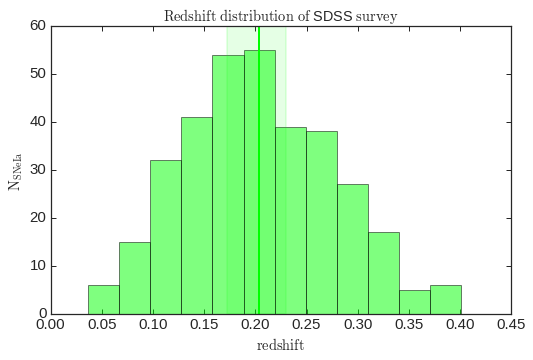

In [8]:
reload(simplots)

test.redshift_one(nb_z.value, True, True)

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/hist_'
#            + str(su.value) + '_095_cuts.pdf', bbox_inches='tight')

## Tracé du stretch de l'échantillon choisi, coupé à zmax

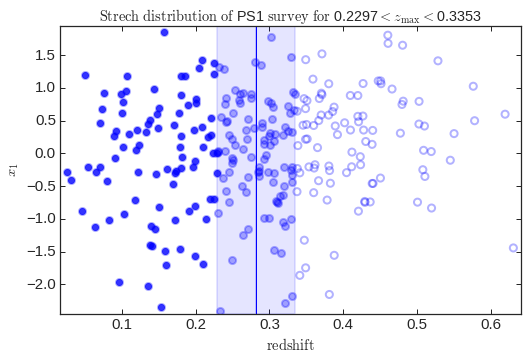

In [13]:
test.stretch_one()

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretch_'
#            + str(su.value) + '_spec_cuts.pdf', bbox_inches='tight')

## Tracé total : $x_1$, $z$, $z_{\mathrm{cuts}}$, histogrammes

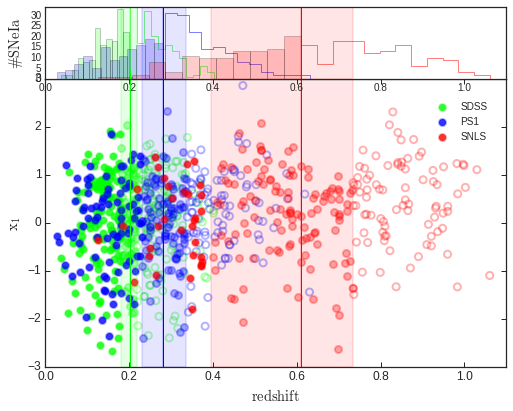

In [3]:
reload(simplots)

test.plot_all(nb_x.value, True, False, False, False)

In [33]:
np.asarray(list(test.z_zcuts.values()))[2]

array([0.50349, 0.4952 , 0.37129, 0.35568, 0.28391, 0.46691, 0.59091,
       0.2102 , 0.5592 , 0.5834 , 0.37016, 0.35816, 0.52216, 0.59116,
       0.35819, 0.45138, 0.55239, 0.34039, 0.54891, 0.42291, 0.46891,
       0.5632 , 0.57921, 0.58621, 0.4892 , 0.32416, 0.18516, 0.42816,
       0.57516, 0.51116, 0.35116, 0.34916, 0.35486, 0.4194 , 0.48038,
       0.58038, 0.37039, 0.21938, 0.60038, 0.47039, 0.49791, 0.50791,
       0.58791, 0.40591, 0.58392, 0.50016, 0.53316, 0.12516, 0.44316,
       0.40439, 0.57639, 0.55091, 0.43591, 0.30191, 0.58119, 0.34621,
       0.3312 , 0.44939, 0.2916 , 0.46109, 0.26891, 0.60891, 0.57891,
       0.3682 , 0.58421, 0.5892 , 0.5142 , 0.43521, 0.58421, 0.41616,
       0.45117, 0.34916, 0.51416, 0.4704 , 0.26338, 0.3374 , 0.51491,
       0.47091, 0.5652 , 0.55819, 0.2622 , 0.5592 , 0.48016, 0.47516,
       0.41816, 0.53516, 0.60916, 0.51539, 0.57938, 0.46138, 0.24639,
       0.53591, 0.37091, 0.37391, 0.60392, 0.53491, 0.40091, 0.37191,
       0.53216, 0.55

In [29]:
np.max(np.asarray(list(test.z_zcuts.values())),
       np.asarray(list(test.z_zmincuts.values())))

TypeError: only integer scalar arrays can be converted to a scalar index

## Tracé total : $c$, $z$, $z_{\mathrm{cuts}}$, histogrammes

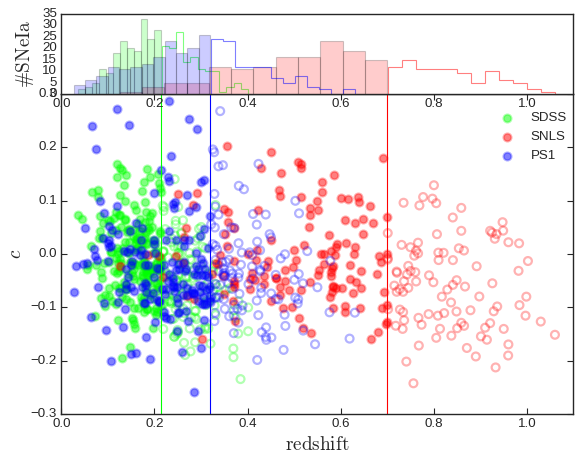

In [79]:
plt.style.use(['classic', 'seaborn-white'])

alpha3colors = {'SDSS': (0,1,0,.3),
                'SNLS': (1,0,0,.3),
                'PS1': (0,0,1,.3),
                'HST': (.5,0,.5,.3),
                'SNF': (1,.647,0,.3)}

alpha5colors = {'SDSS': (0,1,0,.5),
                'SNLS': (1,0,0,.5),
                'PS1': (0,0,1,.5),
                'HST': (.5,0,.5,.5),
                'SNF': (1,.647,0,.5)}

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
ax2 = fig.add_axes([0.1, 0.92, 0.8, 0.2])
#ax3 = fig.add_axes([0.9, 0.12, 0.2, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys[:3]:
    ax.scatter(z_zcuts[survey],
               c_zcuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor=alpha5colors[survey],
               label=survey)
    ax.scatter(z_zmincuts[survey],
               c_zmincuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor="None")
    ax.vline(zmax[survey],
             color=colors[survey])
    
    ax2.hist(z_zcuts[survey], bins = nb_x.value,
             color = colors[survey], alpha = .2)
    ax2.hist(z_zmincuts[survey], bins = nb_x.value,
             color = colors[survey], alpha = .5, histtype='step')

#    ax3.hist(x1_zmincuts[survey], bins = nb_x.value, orientation='horizontal',
#             color = colors[survey], alpha = .2)
#    ax3.hist(x1_zcuts[survey], bins = nb_x.value, orientation='horizontal',
#             color = colors[survey], alpha = .5, histtype='step')
    
ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlim(0, 1.1)
ax.set_ylim(-.3, .3)
ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$c$ ", fontsize="x-large")

ax2.set_xlim(0, 1.1)
ax2.set_ylabel(r"$\mathrm{\# SNe Ia}$ ", fontsize="x-large")

#ax3.set_xlabel(r"$\mathrm{\# SNe Ia}$ ", fontsize="x-large")

ax.legend(ncol=1, loc='lower left', fontsize='medium',
          bbox_to_anchor=(0.82, 0.75))

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/surveys_cuts_c.pdf', bbox_inches='tight')

## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$

### Définitions pour loi

In [130]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

def d(z):
    return stretchevol.MockEvol().delta(z)

def age_law_snf(z):
    """Analytical law with snf results"""
    return d(z)*snf_mu_1 + (1-d(z))*(snf_a*snf_mu_1 + (1-snf_a)*snf_mu_2)

### Tracé

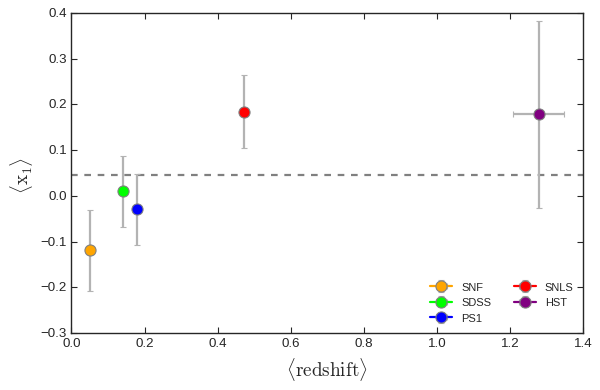

In [134]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys:
    ax.errorbar(z_mean[survey], x1_mean[survey],
                xerr = z_std[survey]/np.sqrt(len(z_zcuts[survey])),
                yerr = x1_std[survey]/np.sqrt(len(x1_zcuts[survey])),
                color = colors[survey], label = survey, **prop)
    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(x1_mean.values())), lw=2, ls="--", color="0.5")

#zz = np.linspace(0,1.4,1000)

#ax.plot(zz, age_law_snf(zz),
#        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_nomodel.pdf')

## Tracé des $c_{\text{mean}}$ en fonction des $z_{\text{mean}}$

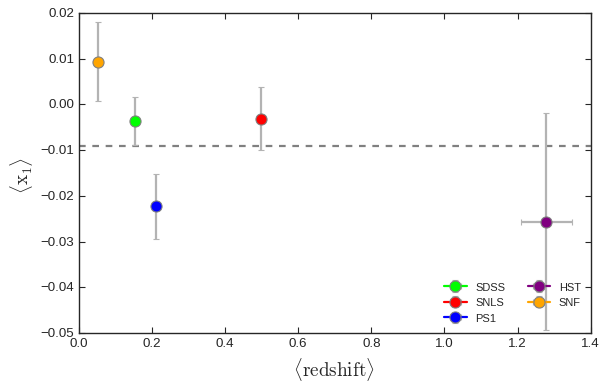

In [80]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
for i in range(5):
#    if i != 4:
#        continue
    ax.errorbar(list(z_mean.values())[i], list(c_mean.values())[i],
                 xerr = list(z_std.values())[i]/np.sqrt(len(list(z_zcuts.values())[i])),
                 yerr = list(c_std.values())[i]/np.sqrt(len(list(c_zcuts.values())[i])), 
                 color = list(colors.values())[i], label = surveys[i], **prop)

    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(c_mean.values())), lw=2, ls="--", color="0.5")

#ax.plot(zz, age_law_snf(zz),
#        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_nomodel.pdf')